In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error as m_a_e, mean_squared_error as m_s_e, r2_score as r2
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lime import lime_tabular

from scipy.stats.mstats import winsorize

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#dataset = "E:/Formation Data Scientist/Projet_4/2016_Building_Energy_Benchmarking.csv"

In [4]:
#raw_df = pd.read_csv(dataset)
_df_ = pd.read_csv('clean_df.csv')

In [5]:
_df_.describe()

,Unnamed: 0,Latitude,Longitude,NumberofBuildings,NumberofFloors,ENERGYSTARScore,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,SiteEnergyUse(kBtu)
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,967.000000,1.440000e+03,1440.000000,1.436000e+03,1440.000000,1440.000000,1440.000000,1440.000000,1.440000e+03
mean,728.482639,47.615850,-122.333765,1.112500,4.349306,63.749741,1.023572e+05,14418.843056,9.455830e+04,0.067361,0.997917,0.712500,177.627243,8.002949e+06
std,421.522776,0.046946,0.023199,1.221129,6.759201,28.806512,1.770243e+05,44731.415406,1.629127e+05,0.250733,0.045612,0.452754,609.768933,1.856069e+07
min,0.000000,47.509590,-122.411820,0.000000,0.000000,1.000000,3.636000e+03,0.000000,5.656000e+03,0.000000,0.000000,0.000000,-0.800000,5.713320e+04
25%,362.750000,47.586950,-122.342740,1.000000,1.000000,44.000000,2.849800e+04,0.000000,2.561000e+04,0.000000,1.000000,0.000000,19.887500,1.240258e+06
50%,729.500000,47.612335,-122.333280,1.000000,3.000000,71.000000,4.687900e+04,0.000000,4.303300e+04,0.000000,1.000000,1.000000,49.040000,2.695255e+06
75%,1092.250000,47.648240,-122.323520,1.000000,5.000000,88.000000,9.626550e+04,0.000000,9.279725e+04,0.000000,1.000000,1.000000,142.052500,7.267172e+06
max,1465.000000,47.733870,-122.261800,27.000000,99.000000,100.000000,2.200000e+06,512608.000000,1.719643e+06,1.000000,1.000000,1.000000,12307.160000,2.930908e+08


In [6]:
clean_df = _df_.drop(columns=['ENERGYSTARScore','Unnamed: 0']).copy()

In [7]:
clean_df.dropna(inplace=True)

In [8]:
clean_df.isna().sum()

PrimaryPropertyType          0
Latitude                     0
Longitude                    0
YearBuilt                    0
NumberofBuildings            0
NumberofFloors               0
PropertyGFABuilding(s)       0
PropertyGFAParking           0
LargestPropertyUseTypeGFA    0
SteamUse(kBtu)               0
Electricity(kBtu)            0
NaturalGas(kBtu)             0
TotalGHGEmissions            0
SiteEnergyUse(kBtu)          0
dtype: int64

In [9]:
clean_df.dtypes

PrimaryPropertyType           object
Latitude                     float64
Longitude                    float64
YearBuilt                     object
NumberofBuildings            float64
NumberofFloors                 int64
PropertyGFABuilding(s)         int64
PropertyGFAParking             int64
LargestPropertyUseTypeGFA    float64
SteamUse(kBtu)                 int64
Electricity(kBtu)              int64
NaturalGas(kBtu)               int64
TotalGHGEmissions            float64
SiteEnergyUse(kBtu)          float64
dtype: object

In [10]:
clean_df

,PrimaryPropertyType,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,SiteEnergyUse(kBtu)
0,Hotel,47.61220,-122.33799,1920_1940,1.0,12,88434,0,88434.0,1,1,1,249.98,7226362.50
1,Hotel,47.61317,-122.33393,1980_2000,1.0,11,88502,15064,83880.0,0,1,1,295.86,8387933.00
2,Hotel,47.61393,-122.33810,1960_1980,1.0,41,759392,196718,756493.0,1,1,1,2089.28,72587024.00
3,Hotel,47.61412,-122.33664,1920_1940,1.0,10,61320,0,61320.0,1,1,1,286.43,6794584.00
4,Hotel,47.61375,-122.34047,1960_1980,1.0,18,113580,62000,123445.0,0,1,1,505.01,14172606.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,Warehouse,47.54425,-122.31776,1940_1960,1.0,1,47863,4222,52085.0,0,1,1,157.70,3605855.50
1436,Small- and Mid-Sized Office,47.53161,-122.29944,1920_1940,1.0,2,24990,0,24990.0,0,1,1,134.80,4420650.50
1437,Other,47.68109,-122.26180,2000_,1.0,1,72000,0,72000.0,0,1,1,67.65,2925780.00
1438,K-12 School,47.58831,-122.30650,2000_,1.0,3,45000,0,45728.0,0,1,0,9.24,1325972.75


In [11]:
clean_df = clean_df.reset_index(drop=True)

In [12]:
clean_df

,PrimaryPropertyType,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,SiteEnergyUse(kBtu)
0,Hotel,47.61220,-122.33799,1920_1940,1.0,12,88434,0,88434.0,1,1,1,249.98,7226362.50
1,Hotel,47.61317,-122.33393,1980_2000,1.0,11,88502,15064,83880.0,0,1,1,295.86,8387933.00
2,Hotel,47.61393,-122.33810,1960_1980,1.0,41,759392,196718,756493.0,1,1,1,2089.28,72587024.00
3,Hotel,47.61412,-122.33664,1920_1940,1.0,10,61320,0,61320.0,1,1,1,286.43,6794584.00
4,Hotel,47.61375,-122.34047,1960_1980,1.0,18,113580,62000,123445.0,0,1,1,505.01,14172606.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1431,Warehouse,47.54425,-122.31776,1940_1960,1.0,1,47863,4222,52085.0,0,1,1,157.70,3605855.50
1432,Small- and Mid-Sized Office,47.53161,-122.29944,1920_1940,1.0,2,24990,0,24990.0,0,1,1,134.80,4420650.50
1433,Other,47.68109,-122.26180,2000_,1.0,1,72000,0,72000.0,0,1,1,67.65,2925780.00
1434,K-12 School,47.58831,-122.30650,2000_,1.0,3,45000,0,45728.0,0,1,0,9.24,1325972.75


Les deux features catégorielles doivent etre converti avant utilisation dans les modèles

In [13]:
df_encoded = pd.get_dummies(clean_df ,columns=['PrimaryPropertyType','YearBuilt'])

In [14]:
df_encoded

,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),...,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,YearBuilt_1920_1940,YearBuilt_1940_1960,YearBuilt_1960_1980,YearBuilt_1980_2000,YearBuilt_2000_,YearBuilt__1920
0,47.61220,-122.33799,1.0,12,88434,0,88434.0,1,1,1,...,0,0,0,0,1,0,0,0,0,0
1,47.61317,-122.33393,1.0,11,88502,15064,83880.0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
2,47.61393,-122.33810,1.0,41,759392,196718,756493.0,1,1,1,...,0,0,0,0,0,0,1,0,0,0
3,47.61412,-122.33664,1.0,10,61320,0,61320.0,1,1,1,...,0,0,0,0,1,0,0,0,0,0
4,47.61375,-122.34047,1.0,18,113580,62000,123445.0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1431,47.54425,-122.31776,1.0,1,47863,4222,52085.0,0,1,1,...,0,0,1,0,0,1,0,0,0,0
1432,47.53161,-122.29944,1.0,2,24990,0,24990.0,0,1,1,...,0,0,0,0,1,0,0,0,0,0
1433,47.68109,-122.26180,1.0,1,72000,0,72000.0,0,1,1,...,0,0,0,0,0,0,0,0,1,0
1434,47.58831,-122.30650,1.0,3,45000,0,45728.0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [15]:
features = df_encoded.drop(columns = ["TotalGHGEmissions","SiteEnergyUse(kBtu)"])

In [16]:
features_names = features.columns

In [17]:
features_names

Index(['Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFABuilding(s)', 'PropertyGFAParking',
       'LargestPropertyUseTypeGFA', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'PrimaryPropertyType_Distribution Center',
       'PrimaryPropertyType_Hospital', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Laboratory',
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property', 'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Refrigerated Warehouse',
       'PrimaryPropertyType_Restaurant', 'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Senior Care Community',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Supermarket / Grocery Store',
       'PrimaryPropertyType_University', 'PrimaryPropertyType_Warehou

In [18]:
train, test = train_test_split(df_encoded, test_size=0.3, random_state=0) 

In [19]:
X1_train, y1_train, X1_test, y1_test = train.drop(columns = ["TotalGHGEmissions","SiteEnergyUse(kBtu)"]), train["SiteEnergyUse(kBtu)"],test.drop(columns = ["TotalGHGEmissions",'SiteEnergyUse(kBtu)']) ,test["SiteEnergyUse(kBtu)"]

## <a name='C2'> Prédictions de la consomation d'énergie   </a>

In [20]:
""" scaler = StandardScaler()
scaler.fit(X1_train)
X1_train = scaler.transform(X1_train)
X1_test = scaler.transform(X1_test) """

' scaler = StandardScaler()\nscaler.fit(X1_train)\nX1_train = scaler.transform(X1_train)\nX1_test = scaler.transform(X1_test) '

In [21]:
r_forest = RandomForestRegressor(random_state=0)

In [22]:
# entrainement du modèle
r_forest.fit(X1_train, y1_train)

RandomForestRegressor(random_state=0)

In [23]:
# prédiction
preds = r_forest.predict(X1_test)

# calcul du RMSE
print(m_s_e(y1_test,preds, squared=False))

10442871.990504038


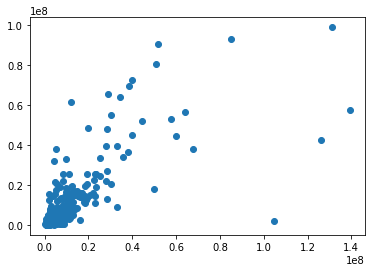

In [24]:
plt.scatter(preds,y1_test)

In [25]:
def get_error(n_estimator, X_train, X_test, y_train, y_test):
    model = RandomForestRegressor(n_estimators=n_estimator, random_state=12)
    model.fit(X_train, y_train)
    preds_val = model.predict(X_test)
    rmse = m_s_e(y_test, preds_val,squared=False)
    mae = m_a_e(y_test, preds_val)
    r_2 = r2(y_test,preds_val)
    return(rmse, mae, r_2)

In [26]:
# comparer RMSE et r2 avec differents valeurs de n_estimator
lst_rmse = []
lst_mae = []
lst_r2 = []
for n_estimator in [100, 200, 300, 400, 500]:
    my_rmse = get_error(n_estimator, X1_train, X1_test, y1_train, y1_test)
    lst_rmse.append(my_rmse[0])
    lst_mae.append(my_rmse[1])
    lst_r2.append(my_rmse[2])
    print("N_Estimator: %d  \t\t RMSE:  %f  \t\t MAE: %f  \t\t R2:  %f" %(n_estimator, my_rmse[0], my_rmse[1], my_rmse[2]))

N_Estimator: 100  		 RMSE:  10577788.286287  		 MAE: 4132718.023841  		 R2:  0.447130
N_Estimator: 200  		 RMSE:  10531946.934994  		 MAE: 4100851.056966  		 R2:  0.451911
N_Estimator: 300  		 RMSE:  10370764.748466  		 MAE: 4073484.117337  		 R2:  0.468559
N_Estimator: 400  		 RMSE:  10306003.850919  		 MAE: 4067186.111738  		 R2:  0.475176
N_Estimator: 500  		 RMSE:  10231094.185447  		 MAE: 4053105.091864  		 R2:  0.482777


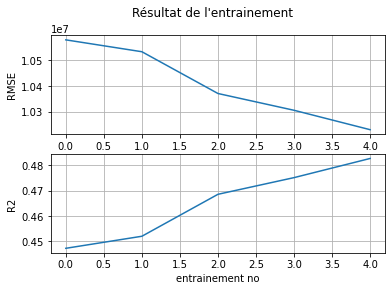

In [27]:
fig,(ax1,ax2) = plt.subplots(2,1)
fig.suptitle('Résultat de l\'entrainement')

ax1.plot(lst_rmse)
ax1.set_ylabel('RMSE')
ax1.set_xlabel('entrainement no')
ax1.grid()

ax2.plot(lst_r2)
ax2.set_ylabel('R2')
ax2.set_xlabel('entrainement no')
ax2.grid()

plt.show()

### - Dummy Regressor

In [28]:
dummy_param_grid = {'strategy' : ['mean','median']}

In [29]:
CV_dummy_mean = GridSearchCV(estimator=DummyRegressor(), param_grid=dummy_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_dummy_mean.fit(X1_train, y1_train)

GridSearchCV(cv=5, estimator=DummyRegressor(),
             param_grid={'strategy': ['mean', 'median']}, refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [30]:
CV_dummy_mean.best_score_

-0.00017351548195936316

In [31]:
dummy_model = CV_dummy_mean.best_estimator_

In [32]:
dummy_model.score(X1_test,y1_test)

-4.785973174503688e-05

In [33]:
print(f"Score - training data: {round(CV_dummy_mean.score(X1_train,y1_train)*100,2)} %")
print(f"Score - test data: {round(CV_dummy_mean.score(X1_test,y1_test)*100,2)} %")

Score - training data: 0.0 %
Score - test data: -0.0 %


In [34]:
results_dummy = pd.DataFrame(CV_dummy_mean.cv_results_)

### - Random Forest Regressor


In [35]:
rfr_param_grid = {'n_estimators' : [100,200,300,400,500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [4,5,6,7,8],
              'random_state': [12]}

In [36]:
CV_rfr = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rfr_param_grid, cv= 5,scoring=['r2','neg_mean_squared_error','neg_root_mean_squared_error'],refit='r2')
CV_rfr.fit(X1_train, y1_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [12]},
             refit='r2',
             scoring=['r2', 'neg_mean_squared_error',
                      'neg_root_mean_squared_error'])

In [37]:
CV_rfr.best_params_

{'max_depth': 7,
 'max_features': 'auto',
 'n_estimators': 100,
 'random_state': 12}

In [38]:
CV_rfr.best_score_

0.7788113729320812

In [39]:
rfr_model= CV_rfr.best_estimator_

In [40]:
rfr_model.score(X1_test,y1_test)

0.43725211642536677

In [41]:
print(f"Score - training data: {round(CV_rfr.score(X1_train,y1_train)*100,1)} %")
print(f"Score - test data: {round(CV_rfr.score(X1_test,y1_test)*100,1)} %")

Score - training data: 94.8 %
Score - test data: 43.7 %


In [42]:
results_forest = pd.DataFrame(CV_rfr.cv_results_)

### - Ridge Regressor

In [43]:
ridge_param_grid = {'alpha' : [1e-3, 1e-2, 1e-1, 1, 2, 5, 10],
              }

In [44]:
CV_ridge = GridSearchCV(estimator=Ridge(), param_grid=ridge_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_ridge.fit(X1_train, y1_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 2, 5, 10]}, refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [45]:
CV_ridge.best_score_

0.7993601186160796

In [46]:
model_ridge = CV_ridge.best_estimator_
print(model_ridge)

Ridge(alpha=0.1)


In [47]:
model_ridge.score(X1_test,y1_test)

0.21839439922291604

In [48]:
print(f"Score - training data: {round(CV_ridge.score(X1_train,y1_train)*100,1)} %")
print(f"Score - test data: {round(CV_ridge.score(X1_test,y1_test)*100,1)} %")

Score - training data: 84.2 %
Score - test data: 21.8 %


In [49]:
results_ridge = pd.DataFrame(CV_ridge.cv_results_)

### - KNN Regressor

In [50]:
knn_param_grid = {'n_neighbors' : list(range(10, 100)),
              }

In [51]:
CV_knn = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=knn_param_grid, cv= 6,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_knn.fit(X1_train, y1_train)

GridSearchCV(cv=6, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                         20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                                         30, 31, 32, 33, 34, 35, 36, 37, 38, 39, ...]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [52]:
CV_knn.best_score_

0.5050781543927921

In [53]:
model_knn = CV_knn.best_estimator_

In [54]:
model_knn.score(X1_test,y1_test)

0.6072138244841041

In [55]:
print(f"Score - training data: {round(CV_knn.score(X1_train,y1_train)*100,1)} %")
print(f"Score - test data: {round(CV_knn.score(X1_test,y1_test)*100,1)} %")

Score - training data: 51.0 %
Score - test data: 60.7 %


In [56]:
CV_knn.best_params_

{'n_neighbors': 23}

In [57]:
results_knn = pd.DataFrame(CV_knn.cv_results_)

### - XGBoost

In [58]:
xgboost_param_grid = {'n_estimators' : [100,200,300,400,500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [4,5,6,7,8],
              'random_state': [12]}

In [59]:
CV_xgboost = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=xgboost_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_xgboost.fit(X1_train, y1_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [12]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [60]:
CV_xgboost.best_score_

0.8055365517986954

In [61]:
model_boosted = CV_xgboost.best_estimator_

In [62]:
model_boosted.score(X1_test,y1_test)

0.68125079975955

In [63]:
y_pred = model_boosted.predict(X1_test)

In [64]:
predictions = pd.DataFrame({'Actual': y1_test,
                           'Predicted': y_pred})

In [65]:
predictions

,Actual,Predicted
651,3.343550e+06,3.526386e+06
411,5.792926e+06,8.933323e+06
342,2.225512e+06,4.458311e+06
1298,1.327069e+07,3.204964e+07
483,1.624611e+07,1.700472e+07
...,...,...
1051,2.563986e+06,1.993573e+06
1374,1.554599e+06,3.115677e+06
549,7.783558e+05,5.413997e+05
864,9.336239e+06,8.996242e+06


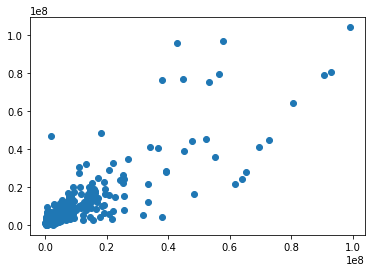

In [66]:
plt.scatter(predictions['Actual'],predictions['Predicted'])

In [67]:
def get_errors(y_test,y_pred):
    rmse = m_s_e(y_test, y_pred,squared=False)
    mae = m_a_e(y_test, y_pred)
    r_2 = r2(y_test,y_pred)
    mean_ = np.mean(y1_test)
    return (r_2, rmse, mae, mean_)

In [68]:
get_errors(y1_test,y_pred)

(0.68125079975955, 8031706.179660161, 3774207.2114011957, 8085300.814842019)

In [69]:
CV_xgboost.best_params_

{'max_depth': 6,
 'max_features': 'sqrt',
 'n_estimators': 100,
 'random_state': 12}

In [70]:
print(f"Score - training data: {round(CV_xgboost.score(X1_train,y1_train)*100,1)} %")
print(f"Score - test data: {round(CV_xgboost.score(X1_test,y1_test)*100,1)} %")

Score - training data: 99.2 %
Score - test data: 68.1 %


    Feature Importance                                     Feature Name
11            0.281745                     PrimaryPropertyType_Hospital
4             0.166234                           PropertyGFABuilding(s)
6             0.158603                        LargestPropertyUseTypeGFA
2             0.117849                                NumberofBuildings
3             0.063775                                   NumberofFloors
0             0.058240                                         Latitude
1             0.037209                                        Longitude
5             0.024618                               PropertyGFAParking
32            0.009925                              YearBuilt_1980_2000
30            0.008925                              YearBuilt_1940_1960
7             0.008371                                   SteamUse(kBtu)
15            0.008214                 PrimaryPropertyType_Large Office
18            0.007795                        PrimaryPropertyTyp

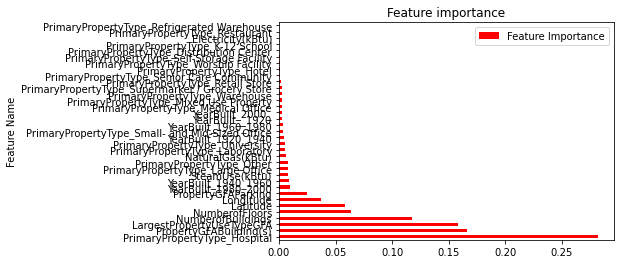

In [71]:
def display_feat_imp_xgboost(boosted):
  feat_imp = model_boosted.feature_importances_
  df_featimp = pd.DataFrame(feat_imp, columns = {"Feature Importance"})
  df_featimp["Feature Name"] = features_names
  df_featimp = df_featimp.sort_values(by="Feature Importance", ascending=False)
  print(df_featimp)
  df_featimp.plot.barh(y="Feature Importance", x="Feature Name", title="Feature importance", color="red")
 
display_feat_imp_xgboost(model_boosted)

In [72]:
explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(X1_train),
                                                   feature_names=features_names,
                                                   mode="regression",
                                                   feature_selection='auto',
                                                   random_state=0)

In [73]:
_exp = explainer.explain_instance(data_row=pd.DataFrame(X1_test).iloc[250],
                                           predict_fn=CV_xgboost.predict)

In [74]:
_exp.show_in_notebook(show_table=True)

In [75]:
results_xgboost = pd.DataFrame(CV_xgboost.cv_results_)

In [76]:
index = ['Dummy','Random Forest','Ridge','KNN','XGBoost']
columns = ['test score']
columns_b = ['validation score']

## <a name='C2'> ENERGYSTARScore   </a>

In [77]:
df_EES = _df_.drop(columns='Unnamed: 0').copy()

In [78]:
df_EES.isna().sum()

PrimaryPropertyType            0
Latitude                       0
Longitude                      0
YearBuilt                      0
NumberofBuildings              0
NumberofFloors                 0
ENERGYSTARScore              473
PropertyGFABuilding(s)         0
PropertyGFAParking             0
LargestPropertyUseTypeGFA      4
SteamUse(kBtu)                 0
Electricity(kBtu)              0
NaturalGas(kBtu)               0
TotalGHGEmissions              0
SiteEnergyUse(kBtu)            0
dtype: int64

In [79]:
df_EES = df_EES.dropna(axis=0)

In [80]:
df_EES.isna().sum()

PrimaryPropertyType          0
Latitude                     0
Longitude                    0
YearBuilt                    0
NumberofBuildings            0
NumberofFloors               0
ENERGYSTARScore              0
PropertyGFABuilding(s)       0
PropertyGFAParking           0
LargestPropertyUseTypeGFA    0
SteamUse(kBtu)               0
Electricity(kBtu)            0
NaturalGas(kBtu)             0
TotalGHGEmissions            0
SiteEnergyUse(kBtu)          0
dtype: int64

In [81]:
df_EES_encoded = pd.get_dummies(df_EES ,columns=['PrimaryPropertyType','YearBuilt'])

In [82]:
df_EES_encoded

,Latitude,Longitude,NumberofBuildings,NumberofFloors,ENERGYSTARScore,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),...,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,YearBuilt_1920_1940,YearBuilt_1940_1960,YearBuilt_1960_1980,YearBuilt_1980_2000,YearBuilt_2000_,YearBuilt__1920
0,47.61220,-122.33799,1.0,12,60.0,88434,0,88434.0,1,1,...,0,0,0,0,1,0,0,0,0,0
1,47.61317,-122.33393,1.0,11,61.0,88502,15064,83880.0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,47.61393,-122.33810,1.0,41,43.0,759392,196718,756493.0,1,1,...,0,0,0,0,0,0,1,0,0,0
3,47.61412,-122.33664,1.0,10,56.0,61320,0,61320.0,1,1,...,0,0,0,0,1,0,0,0,0,0
4,47.61375,-122.34047,1.0,18,75.0,113580,62000,123445.0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1433,47.62263,-122.33976,1.0,12,98.0,317189,166208,342173.0,0,1,...,0,0,0,0,0,0,0,0,1,0
1434,47.65476,-122.34732,1.0,4,72.0,85284,41539,88157.0,0,1,...,0,0,0,0,0,0,0,0,1,0
1435,47.54425,-122.31776,1.0,1,37.0,47863,4222,52085.0,0,1,...,0,0,1,0,0,1,0,0,0,0
1436,47.53161,-122.29944,1.0,2,9.0,24990,0,24990.0,0,1,...,1,0,0,0,1,0,0,0,0,0


- Avec Energy Star Score

In [215]:
train_ESS, test_ESS = train_test_split(df_EES_encoded, test_size=0.25, random_state=1) 

In [216]:
Xe_train, ye_train, Xe_test, ye_test = train_ESS.drop(columns = ["TotalGHGEmissions","SiteEnergyUse(kBtu)"]), train_ESS["SiteEnergyUse(kBtu)"], test_ESS.drop(columns = ["TotalGHGEmissions",'SiteEnergyUse(kBtu)']) , test_ESS["SiteEnergyUse(kBtu)"]

In [217]:
""" scaler = StandardScaler()
scaler.fit(Xe_train)
Xe_train = scaler.transform(Xe_train)
Xe_test = scaler.transform(Xe_test) """

' scaler = StandardScaler()\nscaler.fit(Xe_train)\nXe_train = scaler.transform(Xe_train)\nXe_test = scaler.transform(Xe_test) '

- Entrainement avec les meilleurs paramètres du XGBoost

In [218]:
xGBoost_ESS = GradientBoostingRegressor(**CV_xgboost.best_params_)

In [219]:
xGBoost_ESS.fit(Xe_train, ye_train)

GradientBoostingRegressor(max_depth=6, max_features='sqrt', random_state=12)

In [220]:
xGBoost_ESS.score(Xe_test,ye_test)

0.8799290920474845

    Feature Importance                                     Feature Name
2             0.229813                                NumberofBuildings
5             0.189564                           PropertyGFABuilding(s)
7             0.175781                        LargestPropertyUseTypeGFA
12            0.143202                     PrimaryPropertyType_Hospital
3             0.047704                                   NumberofFloors
1             0.044113                                        Longitude
4             0.025464                                  ENERGYSTARScore
6             0.022571                               PropertyGFAParking
0             0.021107                                         Latitude
15            0.019799                 PrimaryPropertyType_Large Office
28            0.013337                              YearBuilt_1960_1980
31            0.012454                                  YearBuilt__1920
8             0.009885                                   SteamUs

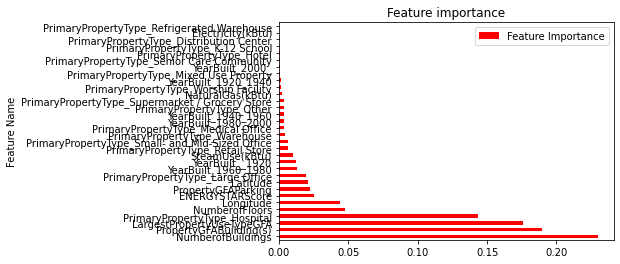

In [229]:
def display_feat_imp_xgboost(boosted):
  feat_imp = xGBoost_ESS.feature_importances_
  df_featimp = pd.DataFrame(feat_imp, columns = {"Feature Importance"})
  df_featimp["Feature Name"] = Xe_train.columns
  df_featimp = df_featimp.sort_values(by="Feature Importance", ascending=False)
  print(df_featimp)
  df_featimp.plot.barh(y="Feature Importance", x="Feature Name", title="Feature importance", color="red")
 
display_feat_imp_xgboost(xGBoost_ESS)

- Sans Energy Star Score

In [222]:
train_S_ESS, test_S_ESS = train_test_split(df_EES_encoded, test_size=0.25, random_state=1) 

In [223]:
Xee_train, yee_train, Xee_test, yee_test = train_S_ESS.drop(columns = ["TotalGHGEmissions","SiteEnergyUse(kBtu)",'ENERGYSTARScore']), train_S_ESS["SiteEnergyUse(kBtu)"], test_S_ESS.drop(columns = ["TotalGHGEmissions","SiteEnergyUse(kBtu)",'ENERGYSTARScore']) , test_S_ESS["SiteEnergyUse(kBtu)"]

In [224]:
""" scaler = StandardScaler()
scaler.fit(Xee_train)
Xee_train = scaler.transform(Xee_train)
Xee_test = scaler.transform(Xee_test) """

' scaler = StandardScaler()\nscaler.fit(Xee_train)\nXee_train = scaler.transform(Xee_train)\nXee_test = scaler.transform(Xee_test) '

In [225]:
xGBoost_S_ESS = GradientBoostingRegressor(**CV_xgboost.best_params_)

In [226]:
xGBoost_S_ESS.fit(Xee_train,yee_train)

GradientBoostingRegressor(max_depth=6, max_features='sqrt', random_state=12)

In [227]:
xGBoost_S_ESS.score(Xee_test,yee_test)

0.8600986734162155

    Feature Importance                                     Feature Name
6             0.252751                        LargestPropertyUseTypeGFA
4             0.208565                           PropertyGFABuilding(s)
11            0.197547                     PrimaryPropertyType_Hospital
2             0.079389                                NumberofBuildings
3             0.058774                                   NumberofFloors
1             0.039017                                        Longitude
0             0.029172                                         Latitude
5             0.026923                               PropertyGFAParking
26            0.018667                              YearBuilt_1940_1960
27            0.018359                              YearBuilt_1960_1980
14            0.012982                 PrimaryPropertyType_Large Office
7             0.012058                                   SteamUse(kBtu)
30            0.010808                                  YearBuil

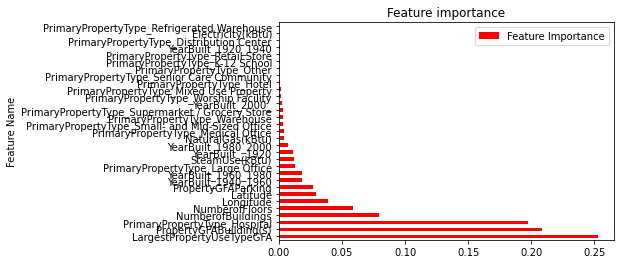

In [230]:
def display_feat_imp_xgboost(boosted):
  feat_imp = xGBoost_S_ESS.feature_importances_
  df_featimp = pd.DataFrame(feat_imp, columns = {"Feature Importance"})
  df_featimp["Feature Name"] = Xee_train.columns
  df_featimp = df_featimp.sort_values(by="Feature Importance", ascending=False)
  print(df_featimp)
  df_featimp.plot.barh(y="Feature Importance", x="Feature Name", title="Feature importance", color="red")
 
display_feat_imp_xgboost(xGBoost_S_ESS)